In [1]:
import itertools
from paddle.vision.datasets import Cifar10,MNIST
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import laplace  

In [2]:
cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
cifar10_train = Cifar10(
    mode= 'train',
    backend="cv2"   # 指定要返回的图像类型：PIL.Image 或 numpy.ndarray。必须是 {'pil'，'cv2'} 中的值
)

mnist_train = MNIST(
    mode= 'train',
    backend="cv2" 
)

#  Differentially Private Pixelization

In [4]:
class PIX:
    def __init__(self,image_size,block_size,m,epsilon):
        '''
        grid cell length b 
        Privacy parameter epsilon
        Number of different pixels allowed m
        '''
        
        self.img_size = image_size

        self.block_size = block_size
        
        self.epsilon = epsilon
        
        self.global_sensitivity = 255 * m/pow(block_size,2)
        
        self.block_num = int((image_size[0] / block_size) * (image_size[1] / block_size))
    
    
    # 分块
    def blocking(self, array):

        h, r = array.shape[0:2]

        blocks = []

        hight = [i * self.block_size for i in range(int(h / self.block_size))]

        width = [i * self.block_size for i in range(int(r / self.block_size))]

        for i in hight:

            for j in width:
                blocks.append(array[i:i + self.block_size, j:j + self.block_size])

        return blocks
    
    def average_pixel_value(self,block_list):
        
        block_avg_value = []
        
        for i in range(self.block_num):
            pixel_avg_value = np.mean(block_list[i])
            block_avg_value.append(pixel_avg_value * np.ones_like(block_list[i]))
            
        return block_avg_value
    
    
    def add_laplace_noise(self,block_list):
        block_add_noise = []
        b = self.global_sensitivity/self.epsilon
        
        for i in range(self.block_num):
            noise = laplace.rvs(loc=0, scale=b, size=block_list[i].size).reshape(block_list[i].shape)
            block_add_noise.append(np.clip(block_list[i] + noise, 0, 255).astype(np.uint8))
            
        return block_add_noise
    
    def block2M(self,block_list):

        Row = []

        Column = []

        blocks=block_list

        for i in range(self.block_num):

            if (i+1)%(self.img_size[1]/self.block_size)!=0:

                Row.append(blocks[i])

            else:

                Row.append(blocks[i])

                Column.append(np.hstack(Row))

                Row=[]

        return np.vstack(Column)
    
    def pixelization(self,img):
        return self.block2M(self.add_laplace_noise(self.average_pixel_value(self.blocking(img))))

In [5]:
encoder = PIX(image_size=(28,28),block_size=4,m=4,epsilon=0.5)

In [9]:
def show(img,imgsize):
    fig = plt.figure(figsize=(10,10)) 
    ax1 = fig.add_subplot(1, 5, 1)  # 2行1列，第1个位置  
    plt.title('original image',fontsize=10)
    ax1.imshow(img,cmap='gray')
    
    img2pix = encoder.pixelization(img)
    print(img2pix.shape)
    ax2 = fig.add_subplot(1, 5, 2)
    plt.title('PIX',fontsize=10)
    ax2.imshow(img2pix,cmap='gray')

(32, 32, 3)
(28, 28, 3)


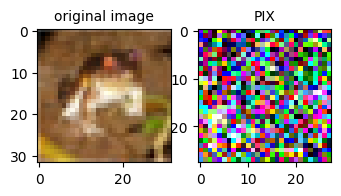

In [13]:
# for img, label in itertools.islice(iter(mnist_train), 1):
#     img = img.astype(np.uint8)
#     print(img.shape)
#     show(img,imgsize=(28,28))
    
for img, label in itertools.islice(iter(cifar10_train), 1):
    img = img.astype(np.uint8)
    print(img.shape)
    show(img,imgsize=(32,32))